In [3]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"]=''
import matplotlib.pyplot as plt
sys.path.append("../")
import tensorflow as tf

from data_utils import SineImage, AROne, EEGData
import numpy as np
import glob, data_utils
from collections import OrderedDict
import gan
import tensorflow_probability as tfp

import time
from importlib import reload
reload(data_utils)

<module 'data_utils' from '../data_utils.py'>

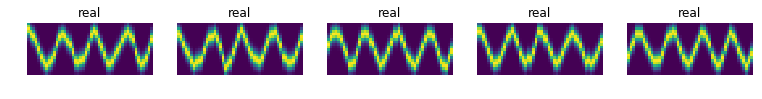

In [14]:
# SINE
time_steps = 48
data_dist = SineImage(length=time_steps, Dx=20, rand_std=0.1)
nsamples = 100
SINE_data_dict = OrderedDict()
SINE_data_dict["real"] = data_dist.batch(nsamples)

fig, axes = plt.subplots(len(SINE_data_dict), 5, figsize=(13,5))
axes = np.atleast_2d(axes)
for ax_row, (name, samples) in zip(axes, SINE_data_dict.items()):
    for i in range(5):
        ax = ax_row[i]
        ax.imshow(samples[i].T, vmin=0, vmax=1)
        ax.set_title(name)
        ax.set_axis_off()

In [15]:
print(SINE_data_dict["real"].shape)

(100, 48, 20)


In [171]:
batch_size = 32
time_steps =48

z_dims_t = 10
y_dims = z_dims_t
Dx = 20

dname = "SineImage"
test = "cot"

g_filter_size = 32
d_filter_size = g_filter_size
g_state_size = 32
d_state_size = 32
p_filter_size = 0

output_activation = 'sigmoid'
z_dims = z_dims_t * time_steps

sinkhorn_eps = 10
sinkhorn_l   = 100
reg_penalty = 10.0
nlstm = 1
seed = 42
lr = 1e-3

In [237]:
SINE_data_dict1 = OrderedDict()
data_dist = SineImage(length=time_steps, Dx=Dx, rand_std=0.1)

z = data_dist.batch(batch_size)
SINE_data_dict1["real"] = z
training = z[:, :time_steps//2, :]

ar_generator = gan.ToyGenerator(batch_size, time_steps//2, z_dims_t, Dx, g_state_size, g_filter_size, 
                                output_activation=output_activation, nlstm=nlstm, nlayer=2, Dy=y_dims, bn=1)
ar_path = '/home/tianlin_xu/ccot-gan/trained/cot/sine_predictions_trained_half/'
ar_generator.load_weights(ar_path)

# training, preds = sample_generator(ar_generator, nsamples, batch_size=batch_size)
preds = ar_generator.call(training, training=False).numpy()
SINE_data_dict1["COT-GAN"] = np.concatenate((training, preds), axis=1)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



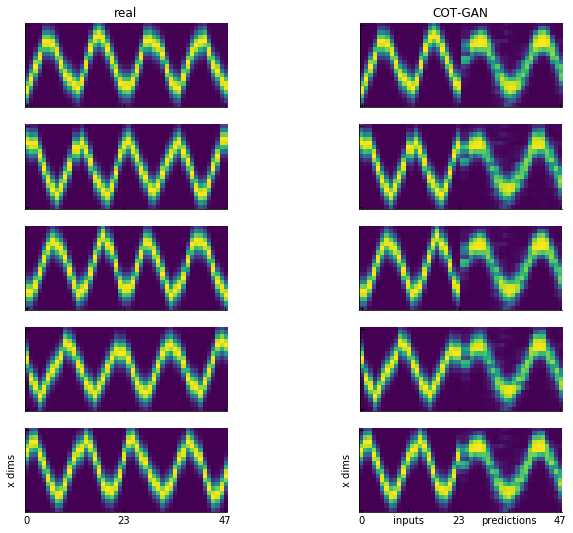

In [238]:
plot_nsample=5
proper_names = ["real", "COT-GAN"]
proper_names = OrderedDict(zip(SINE_data_dict1.keys(), proper_names))

#gs_kw = dict(height_ratios=[1.5,1.5, 1.5], width_ratios=[1]*len(SINE_data_dict))

fig, axes = plt.subplots(plot_nsample, len(SINE_data_dict1), figsize=(11, 9))
axes = np.atleast_2d(axes).T

first_col = True

for ax_row, (name, samples) in zip(axes, SINE_data_dict1.items()):
    for i in range(plot_nsample):
        ax = ax_row[i]
        ax.imshow(samples[i].T, vmin=0, vmax=1)
        ax_row[0].set_title(proper_names[name])
        ax.set_xticks([0, 23, 47])
        ax.set_xlim(-0.5, 47.5)
        ax.set_yticks([0, Dx-1])
        
        if first_col and i==plot_nsample-1:
            #ax.set_xlabel("time steps", labelpad=-3)
            #ax.set_xticklabels([])
            plt.xticks([0, 11, 23, 35, 47], ["0", "inputs", "23", "predictions", "47"])
            ax.set_yticklabels([])
            ax.set_ylabel("x dims")

        else:
            ax.set_xticklabels([])
            ax.set_yticklabels([])

In [247]:
SINE_data_dict = OrderedDict()
data_dist = SineImage(length=time_steps, Dx=Dx, rand_std=0.1)

z = data_dist.batch(batch_size)
print(z.shape)
SINE_data_dict["real"] = z
training = z[:, :time_steps//2, :]

def sample_generator(gen, n, batch_size=batch_size):
    nbatch = n // batch_size + 1
    training = []
    preds = []
    for ni in range(nbatch):
        z = data_dist.batch(batch_size)
        # print(z.shape)
        SINE_data_dict["real"] = z
        training += z[:, :time_steps//2, :],
        p = gen.call(z[:, :time_steps//2, :], training=False).numpy()
        print(p.shape)
        preds += p,
    training = np.concatenate(training, 0)
    preds = np.concatenate(preds, 0)
    return training, preds

(32, 48, 20)


In [248]:
ar_generator = gan.ToyGenerator(batch_size, time_steps//2, z_dims_t, Dx, g_state_size, g_filter_size, 
                                output_activation=output_activation, nlstm=nlstm, nlayer=2, Dy=y_dims, bn=1)
ar_path = '/home/tianlin_xu/ccot-gan/trained/cot/sine_predictions/'
ar_generator.load_weights(ar_path)

# training, preds = sample_generator(ar_generator, nsamples, batch_size=batch_size)
preds = ar_generator.call(training, training=False).numpy()
print(preds.shape)
SINE_data_dict["COT-GAN"] = np.concatenate((training, preds), axis=1)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(32, 24, 20)


In [249]:
plt.rc("axes.spines", right=False)
plt.rc("axes.spines", top=False)
plt.rc("xtick", direction="in")
plt.rc("ytick", direction="in")

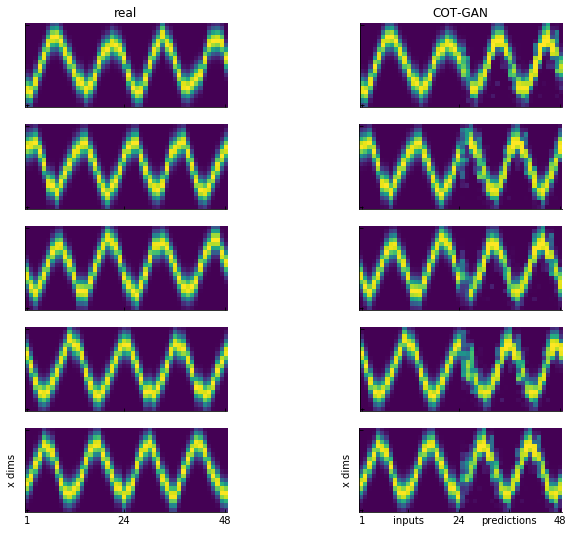

In [250]:
plot_nsample=5
proper_names = ["real", "COT-GAN"]
proper_names = OrderedDict(zip(SINE_data_dict.keys(), proper_names))

#gs_kw = dict(height_ratios=[1.5,1.5, 1.5], width_ratios=[1]*len(SINE_data_dict))

fig, axes = plt.subplots(plot_nsample, len(SINE_data_dict), figsize=(11, 9))
axes = np.atleast_2d(axes).T

first_col = True

for ax_row, (name, samples) in zip(axes, SINE_data_dict.items()):
    for i in range(plot_nsample):
        ax = ax_row[i]
        ax.imshow(samples[i].T, vmin=0, vmax=1)
        ax_row[0].set_title(proper_names[name])
        ax.set_xticks([0, 23, 47])
        ax.set_xlim(-0.5, 47.5)
        ax.set_yticks([0, Dx-1])
        
        if first_col and i==plot_nsample-1:
            #ax.set_xlabel("time steps", labelpad=-3)
            #set tick labels for the first column
            ax.set_xticklabels(["1", "24", "48"])
            #set tick labels for the 2nd column
            plt.xticks([0, 11, 23, 35, 47], ["1", "inputs", "24", "predictions", "48"])
            ax.set_yticklabels([])
            ax.set_ylabel("x dims")

        else:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
#fig.subplots_adjust(hspace=0.3)

In [332]:
SINE_data_dict1 = OrderedDict()
data_dist = SineImage(length=time_steps, Dx=Dx, rand_std=0.1)

z = data_dist.batch(batch_size)
SINE_data_dict1["real"] = z
training = z[:, :time_steps//2, :]

ar_generator = gan.ToyGenerator(batch_size, time_steps//2, z_dims_t, Dx, g_state_size, g_filter_size, 
                                output_activation=output_activation, nlstm=nlstm, nlayer=2, Dy=y_dims, bn=0)
ar_path = '/home/tianlin_xu/ccot-gan/trained/cot/sine_predictions_nobn/'
ar_generator.load_weights(ar_path)

# training, preds = sample_generator(ar_generator, nsamples, batch_size=batch_size)
preds = ar_generator.call(training, training=False).numpy()
SINE_data_dict1["COT-GAN"] = np.concatenate((training, preds), axis=1)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



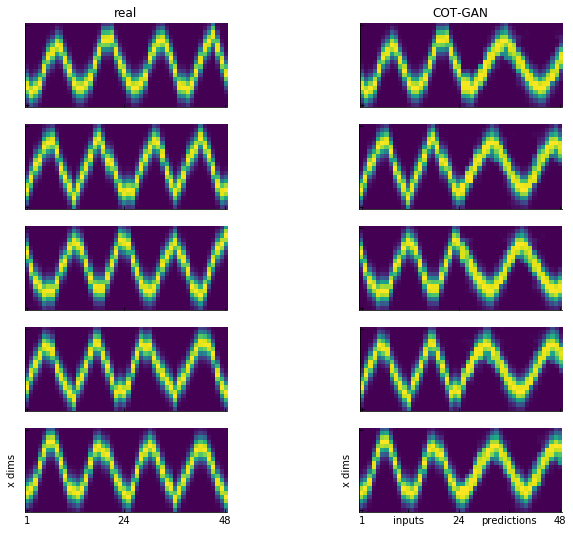

In [333]:
plot_nsample=5
proper_names = ["real", "COT-GAN"]
proper_names = OrderedDict(zip(SINE_data_dict1.keys(), proper_names))

#gs_kw = dict(height_ratios=[1.5,1.5, 1.5], width_ratios=[1]*len(SINE_data_dict))

fig, axes = plt.subplots(plot_nsample, len(SINE_data_dict1), figsize=(11, 9))
axes = np.atleast_2d(axes).T

first_col = True

for ax_row, (name, samples) in zip(axes, SINE_data_dict1.items()):
    for i in range(plot_nsample):
        ax = ax_row[i]
        ax.imshow(samples[i].T, vmin=0, vmax=1)
        ax_row[0].set_title(proper_names[name])
        ax.set_xticks([0, 23, 47])
        ax.set_xlim(-0.5, 47.5)
        ax.set_yticks([0, Dx-1])
        
        if first_col and i==plot_nsample-1:
            #ax.set_xlabel("time steps", labelpad=-3)
            #set tick labels for the first column
            ax.set_xticklabels(["1", "24", "48"])
            #set tick labels for the 2nd column
            plt.xticks([0, 11, 23, 35, 47], ["1", "inputs", "24", "predictions", "48"])
            ax.set_yticklabels([])
            ax.set_ylabel("x dims")

        else:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
#fig.subplots_adjust(hspace=0.3)

In [320]:
class DoubleSineImage(object):
    '''
    :param Dx: dimensionality of of data at each time step
    :param angle: rotation
    :param z0: initial position and velocity
    :param rand_std: gaussian randomness in the latent trajectory
    :param noise_std: observation noise at output
    '''
    def __init__(self, Dx=20, angle=np.pi / 6., z0=None, rand_std=0.0, noise_std=0.0, length=None, amp=1.0):
        super().__init__()
        self.D = 2
        self.Dx = Dx
        self.z0 = z0

        self.A = np.asarray([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        self.rand_std = rand_std
        self.noise_std = noise_std
        self.length = length
        self.amp = amp

    def sample(self, n, T, freq):
        # n: number of samples
        # T: lenght of each sample
        if self.z0 is None:
            z = np.random.randn(n, 2)
            z = z / np.linalg.norm(z, axis=-1, keepdims=True)
        else:
            z = np.tile(self.z0, (n, 1))

        zs = []
        for t in np.arange(T):
            m = self.conditional_param(z)
            z = m + np.random.randn(*m.shape) * self.rand_std
            zs += z,

        zs = np.stack(zs, 1)

        grid = np.linspace(-1.5, 1.5, self.Dx)

        mean = np.exp(- 0.5 * (freq* zs[..., :1] - grid) ** 2 / 0.3 ** 2) * self.amp
        mean = mean.reshape(n, -1)
        xs = mean + np.random.randn(*mean.shape) * self.noise_std

        return zs, xs.reshape(n, T, self.Dx)
    
    def conditional_param(self, zt):
        slope = 1.0
        r = np.sqrt(np.sum(zt ** 2, -1))
        r_ratio = 1.0 / (np.exp(-slope * 4 * (r - 0.3)) + 1) / r

        ztp1 = zt @ self.A
        ztp1 *= r_ratio[..., None]

        return ztp1

    def batch(self, batch_size, freq1=0.3, freq2=1.0):
        # same frequencies 
        first = self.sample(batch_size, self.length, freq1)[1]
        second = self.sample(batch_size, self.length, freq2)[1]
        return first + second

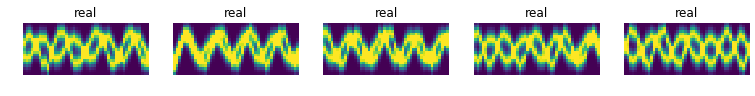

In [325]:
# SINE
time_steps = 48
new_dist = DoubleSineImage(length=time_steps, Dx=Dx, rand_std=0.1)
nsamples = 100
SINE_data_dict2 = OrderedDict()
SINE_data_dict2["real"] = new_dist.batch(nsamples, freq1=0.7)

fig, axes = plt.subplots(len(SINE_data_dict2), 5, figsize=(13,7))
axes = np.atleast_2d(axes)
for ax_row, (name, samples) in zip(axes, SINE_data_dict2.items()):
    for i in range(5):
        ax = ax_row[i]
        ax.imshow(samples[i].T, vmin=0, vmax=1)
        ax.set_title(name)
        ax.set_axis_off()

In [335]:
from scipy.signal import chirp, spectrogram
import matplotlib.pyplot as plt

(48, 1)


<function matplotlib.pyplot.show(*args, **kw)>

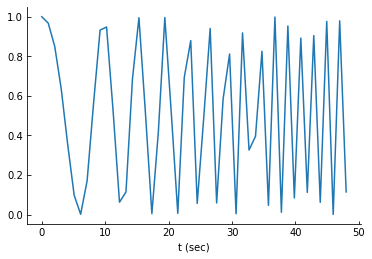

In [393]:
time_steps = 48

t = np.linspace(0, 48, time_steps)

w_array = []

n_sigs = 1

for i in range(n_sigs):
    f0_ = np.random.rand(1)
    f1_ = np.random.rand(1)
    w0 = (chirp(t, f0=f0_, f1=f1_, t1=10, method='linear') + 1.0) / 2.0
    # w0 = np.reshape(w0, (time_steps))
    w_array.append(w0)

w = np.reshape(w_array, (time_steps, n_sigs))
print(w.shape)

for i in range(n_sigs):
    plt.plot(t, w[:, i])
# t.title("Linear Chirp, f(0)=6, f(10)=1")
plt.xlabel('t (sec)')
plt.show


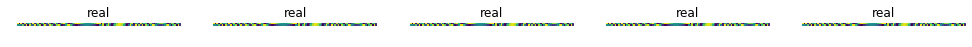

In [382]:
SINE_data_dict2 = OrderedDict()
SINE_data_dict2["real"] = w

fig, axes = plt.subplots(len(SINE_data_dict2), 5, figsize=(17,10))
axes = np.atleast_2d(axes)
for ax_row, (name, samples) in zip(axes, SINE_data_dict2.items()):
    for i in range(5):
        ax = ax_row[i]
        ax.imshow(samples.T, vmin=0, vmax=1)
        ax.set_title(name)
        ax.set_axis_off()

In [411]:
class SineSeries:
    """
      This is a class to create sine series data.
      Attributes:
        length (int): The length of sequences
      """
    def __init__(self, length=15, phase=[-np.pi,np.pi], freq=[0.5,0.5], ampl=[0.8,0.8]):
        self.length = length
        self.phase = phase[0], phase[1]-phase[0]
        self.freq  =freq[0], freq[1]-freq[0]
        self.ampl  =ampl[0], ampl[1]-ampl[0]

    def create_sine_series(self):
        """A function to create random sine time
        series data with pre-determined length.
        """
        self.freq = np.random.rand(2)
        #self.ampl = np.random.rand(2)
        freq = self.freq[0] + self.freq[1] * np.random.random()
        ampl = self.ampl[0] + self.ampl[1] * np.random.random()
        phase = self.phase[0] + self.phase[1] * np.random.random()
        # noise = [np.random.random()*0.3 for i in range(seq_len)]
        x = np.sin(np.arange(0, self.length) * freq + phase) * ampl  # + noise
        x = x + np.random.randn(*x.shape)*0.00
        return x

    def batch(self, batch_size):
        """Method to create a batch of time series examples.
        Args:
          batch_size (int): number of examples in batch
        Returns:
          numpy array of size [batch_size, length]
        """
        batch = np.stack([self.create_sine_series() for _ in range(batch_size)])
        return batch[:,:,None]

(20, 48, 1)


<function matplotlib.pyplot.show(*args, **kw)>

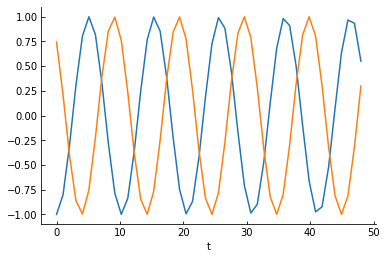

In [454]:
new_dist = SineSeries(length=time_steps, phase=[-np.pi,np.pi], freq=[0.5,0.5], ampl=[1.0,1.0])

w = new_dist.batch(20)
print(w.shape)

for i in range(2):
    plt.plot(t, w[i, :, 0])
# t.title("Linear Chirp, f(0)=6, f(10)=1")
plt.xlabel('t')
plt.show

In [453]:
w = np.reshape(w, (48, 20))

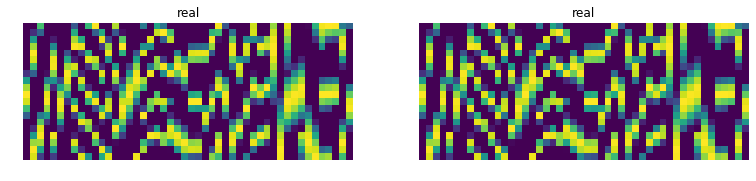

In [450]:
SINE_data_dict2 = OrderedDict()
SINE_data_dict2["real"] = w
n_plots = 2

fig, axes = plt.subplots(len(SINE_data_dict2), n_plots, figsize=(13,7))
axes = np.atleast_2d(axes)
for ax_row, (name, samples) in zip(axes, SINE_data_dict2.items()):
    for i in range(n_plots):
        ax = ax_row[i]
        ax.imshow(samples.T, vmin=0, vmax=1)
        ax.set_title(name)
        ax.set_axis_off()

In [543]:
from numpy import random

def sineimg(img, color='black', linewidth=1.5, linestyle="-"):
    #Random rotation angle
    rot = random.randint(-90, 90)
    rot = 0.0
    x_ = img.shape[0] / np.cos(np.pi * rot / 180)
    y_ = img.shape[1] / np.cos(np.pi * rot / 180)
    X = np.linspace(-1 * x_, x_, img.shape[0])
    Y = np.linspace(-1 * y_, y_, img.shape[0])
    axes = plt.subplot(111)
    np.cos(np.pi * rot / 180)
    #Random amplitude
    amp1 = random.randint(35, 50)
    amp2 = random.randint(35, 50)
    #Random frequency
    frequency1 = X / random.uniform(1.0, 20.0)
    frequency2 = X / random.uniform(1.0, 20.0)
    #Random offset phase
    phase1 = np.pi / random.uniform(1.0, 16.0) + np.pi / 2
    phase2 = np.pi / random.uniform(1.0, 16.0) + np.pi / 3
    #random distance between line cluster
    distance = random.randint(90, 115)
    #distance = 300
    #I need roughly 8 times of them
    for i in range(1):
        Y1 = amp1 * np.sin(frequency1 + phase1) - 450 + i * distance
        Y2 = amp2 * np.sin(frequency2 + phase2) - 420 + i * distance
        x1_trans = X * np.cos(np.pi * rot / 180) - Y1* np.sin(np.pi * rot / 180)
        y1_trans = Y * np.sin(np.pi * rot / 180) + Y1* np.cos(np.pi * rot / 180)
        x2_trans = X * np.cos(np.pi * rot / 180) - Y2* np.sin(np.pi * rot / 180)
        y2_trans = Y * np.sin(np.pi * rot / 180) + Y2* np.cos(np.pi * rot / 180)
        #Remove label
        '''
        axes.set_xticks([])
        axes.set_yticks([])
        axes.spines['right'].set_color('none')
        axes.spines['top'].set_color('none')
        axes.spines['bottom'].set_color('none')
        axes.spines['left'].set_color('none')

        axes.plot(x1_trans, y1_trans, color = color, linewidth=linewidth, linestyle=linestyle)
        axes.plot(x2_trans, y2_trans, color = color, linewidth=linewidth, linestyle=linestyle)
        '''
        print(x1_trans.shape)
        print(y1_trans.shape)
        print(x2_trans.shape)
        print(y2_trans.shape)
    return [x1_trans, y1_trans]

### AR1 Results

In [78]:
batch_size = 32
time_steps = 48

z_dims_t = 10
y_dims = z_dims_t
Dx = 10

dname = "AROne"
test = "cot"

g_filter_size = 32
d_filter_size = g_filter_size
g_state_size = 32
d_state_size = 32
p_filter_size = 0

output_activation = 'linear'
z_dims = z_dims_t * time_steps

sinkhorn_eps = 10
sinkhorn_l   = 100
reg_penalty = 10.0
nlstm = 1
seed = 42
lr = 1e-3
dist_z = tfp.distributions.Uniform(-1, 1)
dist_y = tfp.distributions.Uniform(-1, 1)

# AROne
time_steps = 48
nsamples = 10000
data_dist = AROne(10, time_steps, np.linspace(0.1, 0.9, 10), 0.5)
nsample = 10

In [89]:
data_dict1 = OrderedDict()

z = data_dist.batch(batch_size)
data_dict1["real"] = z[:, time_steps//2:, :]
training = z[:, :time_steps//2, :]

ar_generator = gan.ToyGenerator(batch_size, time_steps//2, z_dims_t, Dx, g_state_size, g_filter_size, 
                                output_activation=output_activation, nlstm=nlstm, nlayer=2, 
                                Dy=y_dims, bn=1)
ar_path = '/home/tianlin_xu/ccot-gan/trained/cot/ar1_preds/'
ar_generator.load_weights(ar_path)

# training, preds = sample_generator(ar_generator, nsamples, batch_size=batch_size)
preds = ar_generator.call(training, training=False).numpy()
# ar1_data_dict1["COT-GAN"] = np.concatenate((training, preds), axis=1)
data_dict1["COT-GAN"] = preds

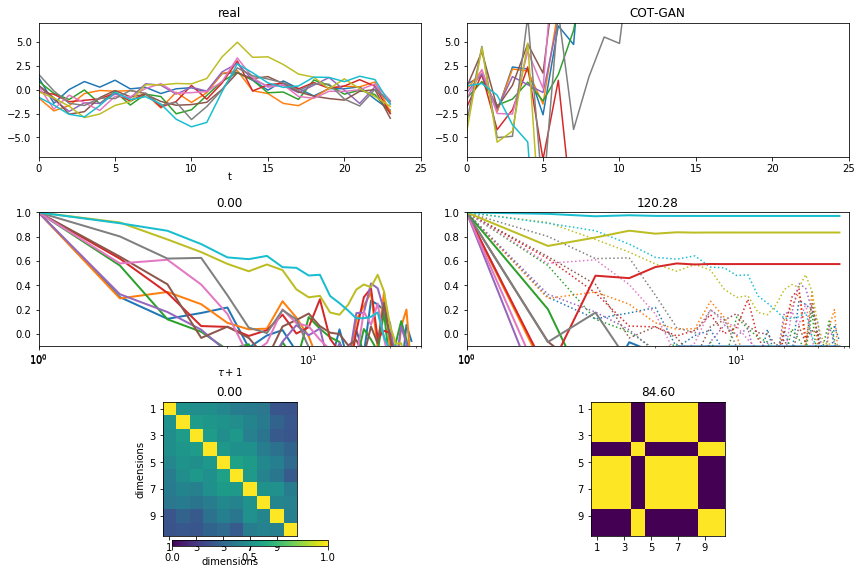

In [90]:
proper_names = ["real", "COT-GAN"]

fig, axes = plt.subplots(3, len(data_dict1), figsize=(12,8))

for ni, name in enumerate(data_dict1.keys()):
    sample = data_dict1[name]
    ax = axes[0,ni]
    ax.plot(sample[0])
    ax.set_ylim([-7.0,7.0])
    ax.set_xlim(0,25)

    ax.set_title(proper_names[ni])

    ax = axes[1,ni]
    autocs = []
    for i in range(10):
        autoc = np.corrcoef(sample[...,i].T)[:,0]
        ax.plot(range(1, 25), autoc, color=f"C{i}", ls="-", lw=2)
        autocs += autoc,
        if ni == 0:
            for j in range(len(data_dict1)-1):
                axes[1,j+1].plot(range(1, 25), autoc, color=f"C{i}", ls=":")
    autocs = np.asarray(autocs)
    if ni == 0:
        autocs_true = autocs
    
    ax.set_title("%.2f"%np.abs(autocs_true - autocs).sum())
    ax.set_xlim(1, 25)
    ax.set_xscale("log")
    ax.set_xticks([1, 5, 15, 20, 25, 26], minor=True)
    ax.set_ylim(-0.1, 1.0)
    

ax = axes[0,0]
ax.set_xlabel("t", labelpad=-2)


ax = axes[1,0]
ax.set_xlabel(r"$\tau+1$", labelpad=-1)

for ni, name in enumerate(data_dict1.keys()):
    ax = axes[2,ni]
    sample = data_dict1[name]
    s_corr = np.corrcoef(sample.reshape(-1, sample.shape[-1]).T)
    im=ax.imshow(s_corr, vmin=0.0,vmax=1)
    if ni == 0:
        true_s_corr = s_corr

    ax.set_xticks(range(0, 10, 2))
    ax.set_xticklabels(range(1, 11, 2))
    ax.set_title("%.2f" % np.abs(s_corr - true_s_corr).sum())
    
    ax.set_yticks(range(0, 10, 2))
    ax.set_yticklabels(range(1, 11, 2))
ax = axes[2,0]
ax.set_xlabel("dimensions")
ax.set_ylabel("dimensions")

fig.tight_layout(pad=0.8)
cax = fig.add_axes([0.2, 0.05, 0.18, 0.01])
fig.colorbar(im, cax=cax, ticks=[0.0,0.5,1.0], orientation="horizontal")
# fig.savefig("../figs/AR_2to_wavegan.pdf", bbox_inches = 'tight', pad_inches=0)

In [85]:
data_dict1 = OrderedDict()

z = data_dist.batch(batch_size)
data_dict1["real"] = z
training = z[:, :time_steps//2, :]

ar_generator = gan.ToyGenerator(batch_size, time_steps//2, z_dims_t, Dx, g_state_size, g_filter_size, 
                                output_activation=output_activation, nlstm=nlstm, nlayer=2, 
                                Dy=y_dims, bn=1)
ar_path = '/home/tianlin_xu/ccot-gan/trained/cot/ar1_preds/'
ar_generator.load_weights(ar_path)

# training, preds = sample_generator(ar_generator, nsamples, batch_size=batch_size)
preds = ar_generator.call(training, training=False).numpy()
data_dict1["COT-GAN"] = np.concatenate((training, preds), axis=1)

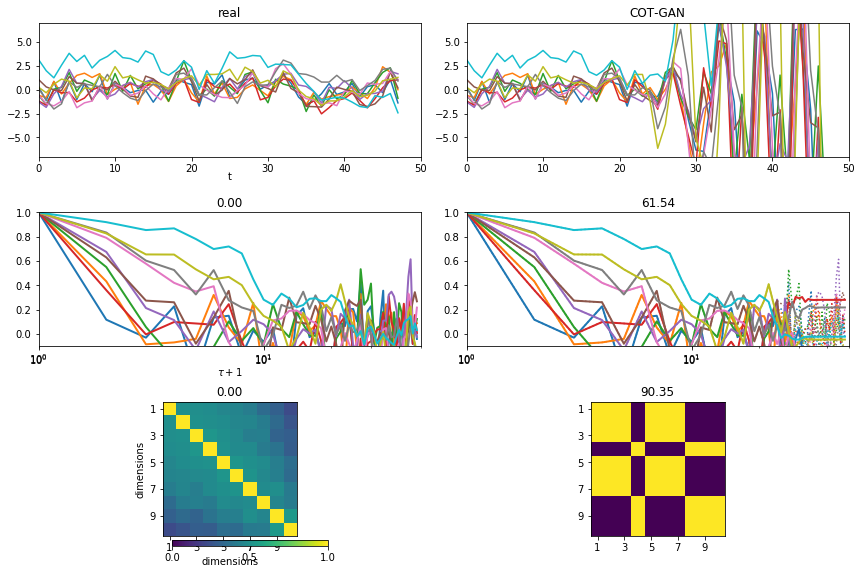

In [86]:
proper_names = ["real", "COT-GAN"]

fig, axes = plt.subplots(3, len(data_dict1), figsize=(12,8))

for ni, name in enumerate(data_dict1.keys()):
    sample = data_dict1[name]
    ax = axes[0,ni]
    ax.plot(sample[0])
    ax.set_ylim([-7.0,7.0])
    ax.set_xlim(0,50)

    ax.set_title(proper_names[ni])

    ax = axes[1,ni]
    autocs = []
    for i in range(10):
        autoc = np.corrcoef(sample[...,i].T)[:,0]
        ax.plot(range(1, 49), autoc, color=f"C{i}", ls="-", lw=2)
        autocs += autoc,
        if ni == 0:
            for j in range(len(data_dict1)-1):
                axes[1,j+1].plot(range(1, 49), autoc, color=f"C{i}", ls=":")
    autocs = np.asarray(autocs)
    if ni == 0:
        autocs_true = autocs
    
    ax.set_title("%.2f"%np.abs(autocs_true - autocs).sum())
    ax.set_xlim(1, 50)
    ax.set_xscale("log")
    ax.set_xticks([1, 10, 20, 30, 40, 50], minor=True)
    ax.set_ylim(-0.1, 1.0)
    

ax = axes[0,0]
ax.set_xlabel("t", labelpad=-2)


ax = axes[1,0]
ax.set_xlabel(r"$\tau+1$", labelpad=-1)

for ni, name in enumerate(data_dict1.keys()):
    ax = axes[2,ni]
    sample = data_dict1[name]
    s_corr = np.corrcoef(sample.reshape(-1, sample.shape[-1]).T)
    im=ax.imshow(s_corr, vmin=0.0,vmax=1)
    if ni == 0:
        true_s_corr = s_corr

    ax.set_xticks(range(0, 10, 2))
    ax.set_xticklabels(range(1, 11, 2))
    ax.set_title("%.2f" % np.abs(s_corr - true_s_corr).sum())
    
    ax.set_yticks(range(0, 10, 2))
    ax.set_yticklabels(range(1, 11, 2))
ax = axes[2,0]
ax.set_xlabel("dimensions")
ax.set_ylabel("dimensions")

fig.tight_layout(pad=0.8)
cax = fig.add_axes([0.2, 0.05, 0.18, 0.01])
fig.colorbar(im, cax=cax, ticks=[0.0,0.5,1.0], orientation="horizontal")
# fig.savefig("../figs/AR_2to_wavegan.pdf", bbox_inches = 'tight', pad_inches=0)